In [1]:
import sys
sys.path.append('../')
import torch 
import torch.nn as nn
from torchvision import datasets,models,transforms
import pandas as pd 
import os
import glob
import numpy as np
from src import config 
import time
import copy

In [2]:
train_df = pd.read_csv(os.path.join('..',config.TRAINING_DATA,'train.csv'))
train_df.head()

,filename,label
0,0-with-mask.jpg,with_mask
1,1-with-mask.jpg,with_mask
2,10-with-mask.jpg,with_mask
3,100-with-mask.jpg,with_mask
4,101-with-mask.jpg,with_mask


In [3]:
test_df = pd.read_csv(os.path.join('..',config.TESTING_DATA,'test.csv'))
test_df.head()

,filename,label
0,augmented_image_227.jpg,with_mask
1,augmented_image_228.jpg,with_mask
2,augmented_image_23.jpg,with_mask
3,augmented_image_230.jpg,with_mask
4,augmented_image_232.jpg,with_mask


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = '../data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

In [6]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1117
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 276
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=4, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [9]:
class_names = image_datasets['train'].classes

In [10]:
class_names

['with_mask', 'without_mask']

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [14]:
dataset_sizes

{'train': 1117, 'test': 276}

In [15]:
# model_ft = models.resnet101(pretrained=True)
model_ft = models.mobilenet_v2(pretrained=True)

# num_frts = model_ft.fc.in_features
num_frts = model_ft.classifier[1].in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = torch.optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\somya/.cache\torch\checkpoints\mobilenet_v2-b0353104.pth
100.0%


In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    training_losses = []
    validation_losses = []
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            training_losses.append(epoch_loss) if phase=='train' else validation_losses.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    
    return model,training_losses,validation_losses

In [17]:
model_ft,training_losses,validation_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.7174 Acc:0.8603

test Loss: 0.0101 Acc:1.0000

Epoch 2/20
----------
train Loss: 0.2501 Acc:0.9132

test Loss: 0.0278 Acc:0.9964

Epoch 3/20
----------
train Loss: 0.1404 Acc:0.9355

test Loss: 0.0201 Acc:1.0000

Epoch 4/20
----------
train Loss: 0.1294 Acc:0.9427

test Loss: 0.0099 Acc:1.0000

Epoch 5/20
----------
train Loss: 0.1170 Acc:0.9570

test Loss: 0.0196 Acc:1.0000

Epoch 6/20
----------
train Loss: 0.1217 Acc:0.9418

test Loss: 0.0216 Acc:0.9964

Epoch 7/20
----------
train Loss: 0.1111 Acc:0.9463

test Loss: 0.0103 Acc:1.0000

Epoch 8/20
----------
train Loss: 0.1074 Acc:0.9552

test Loss: 0.0193 Acc:1.0000

Epoch 9/20
----------
train Loss: 0.1012 Acc:0.9534

test Loss: 0.0127 Acc:1.0000

Epoch 10/20
----------
train Loss: 0.0908 Acc:0.9606

test Loss: 0.0107 Acc:1.0000

Epoch 11/20
----------
train Loss: 0.0861 Acc:0.9606

test Loss: 0.0090 Acc:1.0000

Epoch 12/20
----------
train Loss: 0.1040 Acc:0.9552

test Loss: 0.0110 Acc:1.0000

E

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [22]:
torch.save(model_ft,os.path.join('..','saved_models',f'facemaskdetection_new_mask_types{datetime.now().date()}.pth'))

Text(0.5, 0.98, 'Training History')

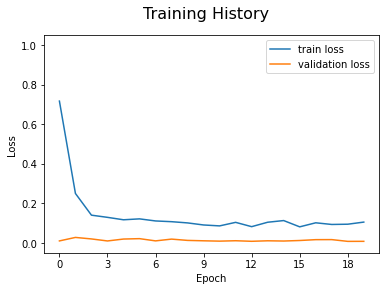

In [23]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

ax.plot(training_losses, label='train loss')
ax.plot(validation_losses, label='validation loss')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([-0.05, 1.05])
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
fig.suptitle('Training History', fontsize=16)
